# Measurement of daily variation of people's activities on LinkedIn using the daily variation of the number of LinkedIn followers well-known companies have.
## The purpose of this analysis is to find which days of week does the LinkedIn pages of US compnies experience maximum and minimum number of increase in followers. This tells us the behaviors of LinkedIn users, that is what time of the day they are mostly active on linked in. This gives insight to companies on what days of the week people arre more likely to visit their LinkedIn page. Also this is a good metric for LinkedIn company as it better understand the variation of visitors' traffick with the days of the week.
## We will use a data that contains the number of LinkedIn followers each day for thousands of US companies. The data was collected from 2015 - 2018. Data is not publicly available. If you need it you can contact me via Github.
# -----------------------------------------------------------------------------------------------------

### Imports modules needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import time
from scipy.optimize import curve_fit
from collections import Counter

### Reads the csv data. The data is a time series data on the number of linkedin followers each day from 2015 - 2018.

In [2]:
df = pd.read_csv("linkedin_company.csv",usecols=['as_of_date','company_name','followers_count','employees_on_platform','industry'], low_memory=False)


### Data exploration

In [3]:
df = pd.read_csv("linkedin_company.csv",low_memory=False)
df.head(5)

,dataset_id,as_of_date,company_name,followers_count,employees_on_platform,link,industry,date_added,date_updated,description,website,entity_id,cusip,isin
0,58329,2015-09-14,Goldman Sachs,552254,38124,https://www.linkedin.com/company/1382,Investment Banking,2015-09-14 00:00:00+00,2015-09-14 00:00:00+00,NaN,NaN,NaN,NaN,NaN
1,58329,2015-09-15,Goldman Sachs,552862,38141,https://www.linkedin.com/company/1382,Investment Banking,2015-09-15 00:00:00+00,2015-09-15 00:00:00+00,NaN,NaN,NaN,NaN,NaN
2,58363,2015-09-16,United Technologies,59157,14982,https://www.linkedin.com/company/2426,Aviation & Aerospace,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,NaN,NaN,NaN,NaN,NaN
3,58366,2015-09-16,Novo Nordisk,336175,26448,https://www.linkedin.com/company/2227,Pharmaceuticals,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,NaN,NaN,NaN,NaN,NaN
4,58371,2015-09-16,"Lowe's Companies, Inc.",134255,62574,https://www.linkedin.com/company/4128,Retail,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,NaN,NaN,NaN,NaN,NaN


### The data has too many columns that we don't need. We are only interested in the variation of change in followers count with each day of the week for any given company. So, we can either load only the columns we need or we slice it from the loaded data. Let's do the later.

In [4]:
LinkedIn_data= df[['as_of_date','company_name','followers_count']]
LinkedIn_data.head(5)

,as_of_date,company_name,followers_count
0,2015-09-14,Goldman Sachs,552254
1,2015-09-15,Goldman Sachs,552862
2,2015-09-16,United Technologies,59157
3,2015-09-16,Novo Nordisk,336175
4,2015-09-16,"Lowe's Companies, Inc.",134255


### Let's check how many companies there are

In [5]:
LinkedIn_data['company_name'].nunique()

5028

### That is too many. Lets see what their average number of followers are like. We will use it to get the top well known companies as the popularity of a company obviously collocates with the number of LinkedIn followers it has. We do this by grouping the data by comany name and then use the 10 companies with largest number of followers in Linkedin for the study.

In [6]:
group = LinkedIn_data.groupby('company_name')['followers_count'].mean().to_frame('mean').reset_index()
group.nlargest(10,'mean').reset_index(drop=True)

,company_name,mean
0,Google,4.983282e+06
1,Microsoft,3.671862e+06
2,Apple,3.400467e+06
3,IBM,3.344379e+06
4,Accenture,2.652317e+06
5,The Wall Street Journal,2.645266e+06
6,The New York Times,2.542032e+06
7,HP,2.531137e+06
8,Amazon,2.421637e+06
9,Hewlett Packard Enterprise,2.414744e+06


### Let us now get the names of those 10 companies

In [7]:
companies = group.nlargest(10,'mean')['company_name'].to_list()
companies

['Google',
 'Microsoft',
 'Apple',
 'IBM',
 'Accenture',
 'The Wall Street Journal',
 'The New York Times',
 'HP',
 'Amazon',
 'Hewlett Packard Enterprise']

### To save memory we need to grab data only from top ten companies above and use them to do the analysis

In [8]:
LinkedIn_data = LinkedIn_data[LinkedIn_data['company_name'].isin(companies)].reset_index(drop = True)
LinkedIn_data.head(5)

,as_of_date,company_name,followers_count
0,2015-09-16,IBM,2542182
1,2015-09-16,Amazon,1311936
2,2015-09-16,Apple,2587280
3,2015-09-16,Google,3615989
4,2015-09-16,Accenture,2063480


### We will now group the new LinkedIn_data by company name for our investigation. We will use Google as an example company. Then convert date to datetime object. Later we will analyze the top 10 companies.

In [9]:
company_df = LinkedIn_data.groupby('company_name')
Google = company_df.get_group('Google')
Google = Google.sort_values(by=['as_of_date'])
Google.reset_index(inplace=True,drop=True)
Google['as_of_date'] = pd.to_datetime(Google['as_of_date'])
Google.head(5)

,as_of_date,company_name,followers_count
0,2015-09-16,Google,3615989
1,2015-09-17,Google,3618814
2,2015-09-18,Google,3622173
3,2015-09-19,Google,3624480
4,2015-09-20,Google,3626696


### We now find the difference in date and likes between successive rows of as_of_date and followers_count columns. We then find rows where the date increased by one. The change in followers for such rows is the daily change. Finally we create a day_name column that contain the day of the week for each row.

In [10]:
Google["day_diff"] = Google['as_of_date'].diff()
Google["change_in_followers_count"]= Google['followers_count'].diff()
Google = Google[Google['day_diff']=='1 days']
Google['day_name'] = Google['as_of_date'].dt.day_name()
Google.head(5)

,as_of_date,company_name,followers_count,day_diff,change_in_followers_count,day_name
1,2015-09-17,Google,3618814,1 days,2825.0,Thursday
2,2015-09-18,Google,3622173,1 days,3359.0,Friday
3,2015-09-19,Google,3624480,1 days,2307.0,Saturday
4,2015-09-20,Google,3626696,1 days,2216.0,Sunday
5,2015-09-21,Google,3629263,1 days,2567.0,Monday


### Now changes in number of followers can be +ve or -ve although we expect that most change will be +ve. However, It doesnt matter if the change is +ve or -ve. What matters is that the absolute value of the change is a measure of peoples activities on that day. So we apply the python absolute value method to the change in followers column.

In [11]:
Google["change_in_followers_count"] = abs(Google["change_in_followers_count"])
Google.head(5)

,as_of_date,company_name,followers_count,day_diff,change_in_followers_count,day_name
1,2015-09-17,Google,3618814,1 days,2825.0,Thursday
2,2015-09-18,Google,3622173,1 days,3359.0,Friday
3,2015-09-19,Google,3624480,1 days,2307.0,Saturday
4,2015-09-20,Google,3626696,1 days,2216.0,Sunday
5,2015-09-21,Google,3629263,1 days,2567.0,Monday


### We now group the dataframe by days of the week and then find average change per each day of the week and then scatter plot it.

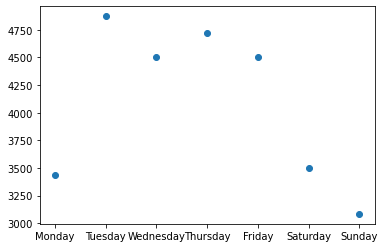

In [12]:
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
Google_week = Google.groupby('day_name').mean()['change_in_followers_count'].reindex(days).to_frame()
plt.scatter(x=Google_week.index, y=Google_week['change_in_followers_count'])

### The scatter plot above suggested a quadratic variation in change in follower count. Lets do a quadratic fit. But first lets get the day maximum change occured.


In [13]:
Google_week[Google_week['change_in_followers_count']==Google_week['change_in_followers_count'].max()].index[0]

'Tuesday'

## Nown unto the quadratic fitting

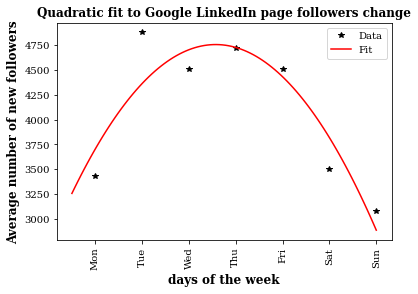

In [14]:
plt.rc('font', family='serif')
days_abbrev = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
def quadratic_fit(x,a,b,c):
    return np.array(a+b*x+c*x**2)

points = [1,2,3,4,5,6,7] #the days of the week
P0 = np.array([1,1,1])
change_in_followers = Google_week['change_in_followers_count'].to_list()
coeffs, matcov = curve_fit(quadratic_fit, points, change_in_followers, P0) # employees' likes
x = np.linspace(0.5,7,100)
y = quadratic_fit(x,*coeffs)
#plots the data
plt.plot(points,change_in_followers,"k*",x,y,"r") # for employees' likes
plt.xticks(points, days_abbrev)
plt.title("Quadratic fit to Google LinkedIn page followers change",size=12,weight ='bold')
plt.xlabel("days of the week",size=12,weight ='bold')
plt.ylabel("Average number of new followers",size=12,weight ='bold')
plt.legend(["Data","Fit"])
plt.xticks(rotation=90)
plt.show()

### A qudratic equation nicely modells the behavior of linkedin visitors. This reveals that Google's LinkedIn page had most visist on midweek with maximum on Tuesdays. There was little visits on weekends and Mondays. Can you think of an explanantion for this?
### Will other companies follow similar trajectory? We will see.
## ----------------------------------------------------------------------------------------------------------------------------

# Bringing all together

In [15]:
df = pd.read_csv("linkedin_company.csv",low_memory=False)

Working on Google ...


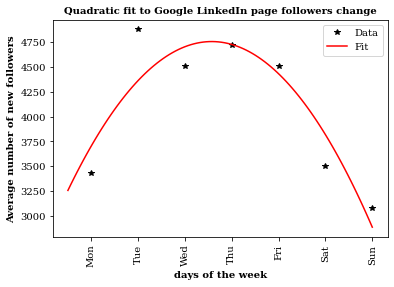

Working on Microsoft ...


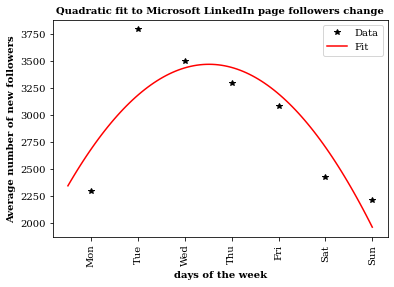

Working on Apple ...


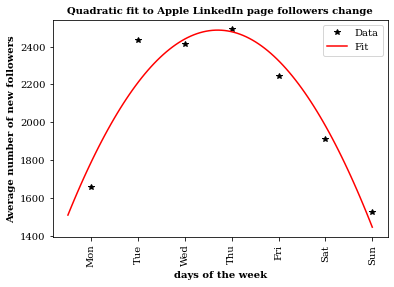

Working on IBM ...


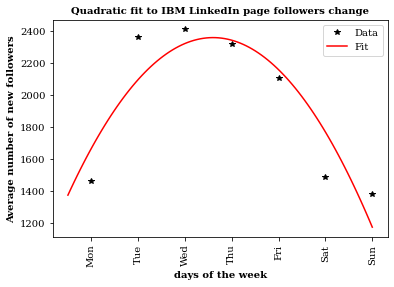

Working on Accenture ...


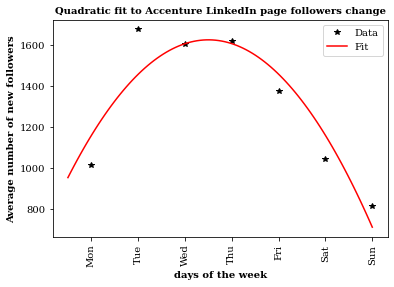

Working on The Wall Street Journal ...


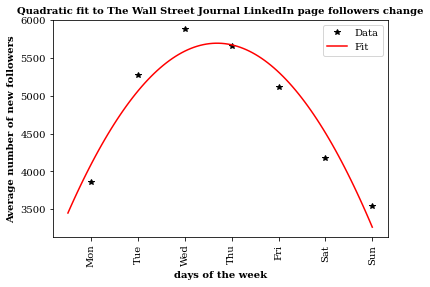

Working on The New York Times ...


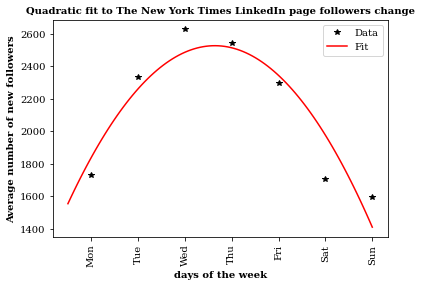

Working on HP ...


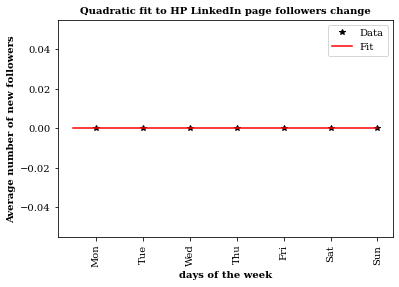

Working on Amazon ...


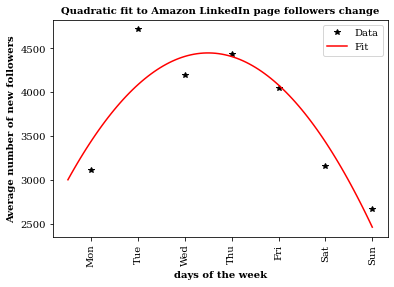

Working on Hewlett Packard Enterprise ...


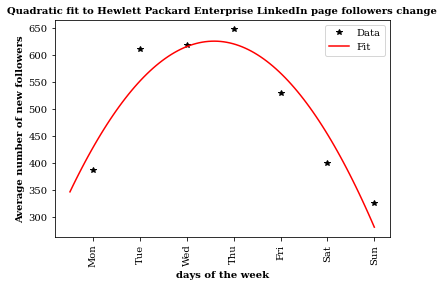

Working on Unilever ...


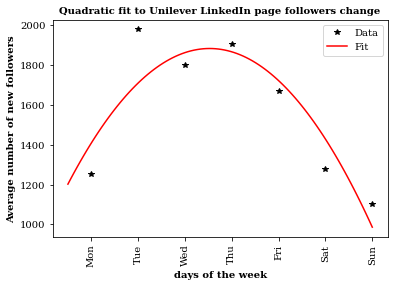

Working on Hewlett-Packard ...


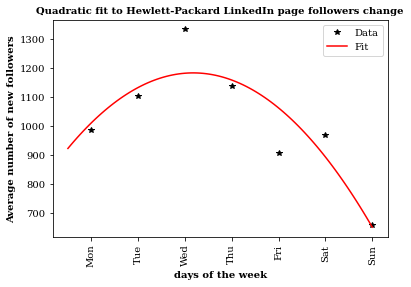

Working on LinkedIn ...


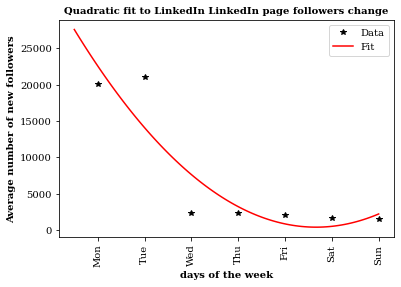

Working on Oracle ...


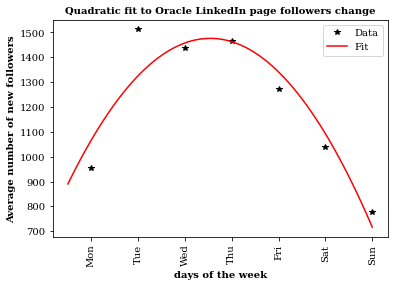

Working on Procter & Gamble ...


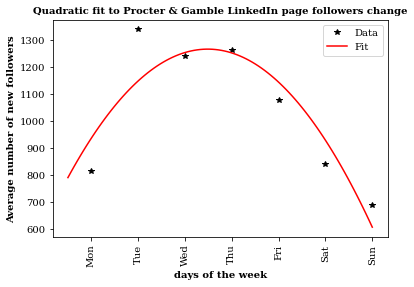

Working on Procter &amp; Gamble ...


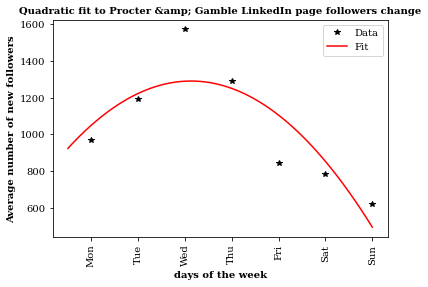

Working on Facebook ...


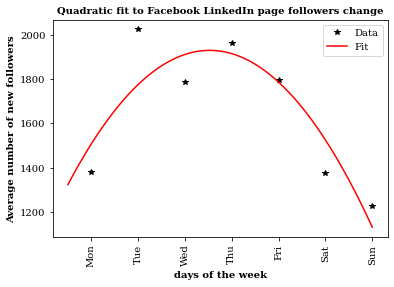

Working on Tata Consultancy Services ...


ValueError: array must not contain infs or NaNs

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import time
from scipy.optimize import curve_fit
from collections import Counter

LinkedIn_data= df[['as_of_date','company_name','followers_count','industry']]
group = LinkedIn_data.groupby('company_name')['followers_count'].mean().to_frame('mean').reset_index()
companies = group.nlargest(500,'mean')['company_name'].to_list()
company_df = LinkedIn_data.groupby('company_name')
week_maximum = []
week_minimum = []
for company in companies:
    print("Working on",company,'...')
    company_data = company_df.get_group(company)
    company_data = company_data.sort_values(by=['as_of_date'])
    company_data.reset_index(inplace=True,drop=True)
    company_data['as_of_date'] = pd.to_datetime(company_data['as_of_date'])
    company_data["day_diff"] = company_data['as_of_date'].diff()
    company_data['day_name'] = company_data['as_of_date'].apply(lambda x: x.day_name())
    company_data["change_in_followers_count"]= company_data['followers_count'].diff()
    company_data = company_data[company_data['day_diff']=='1 days']
    #x = company_data[company_data['change_in_followers']<0]
    #print(x['change_in_followers'])
    company_data["change_in_followers_count"] = abs(company_data["change_in_followers_count"])
    days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    company_data_week = company_data.groupby('day_name').mean()['change_in_followers_count'].reindex(days).to_frame()
    if company_data_week['change_in_followers_count'].any():#check if there is data for the company
        maximum = company_data_week[company_data_week['change_in_followers_count'] \
            ==company_data_week['change_in_followers_count'].max()].index.astype(str)[0]
        week_maximum.append(maximum)
        minimum = company_data_week[company_data_week['change_in_followers_count'] \
            ==company_data_week['change_in_followers_count'].min()].index.astype(str)[0]
        week_minimum.append(minimum)

    #perform fitting
    plt.rc('font', family='serif')
    
    def quadratic_fit(x,a,b,c):
        return np.array(a+b*x+c*x**2)

    points = [1,2,3,4,5,6,7] #the days of the week
    P0 = np.array([1,1,1])
    change_in_followers = company_data_week['change_in_followers_count'].to_list()
    coeffs, matcov = curve_fit(quadratic_fit, points, change_in_followers, P0) # employees' likes
    x = np.linspace(0.5,7,100)
    y = quadratic_fit(x,*coeffs)
    #plots the data
    plt.plot(points,change_in_followers,"k*",x,y,"r") # for employees' likes
    days_abbrev = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    plt.xticks(points, days_abbrev)
    plt.title("Quadratic fit to "+company+" LinkedIn page followers change",size=10,weight ='bold')
    plt.xlabel("days of the week",size=10,weight ='bold')
    plt.ylabel("Average number of new followers",size=10,weight ='bold')
    plt.legend(["Data","Fit"])
    plt.xticks(rotation=90)
    plt.savefig(company+"plot.png",bbox_inches="tight", dpi=200)
    plt.show()
    
print("Done working")
print("The day maximum change in followers counts occured and their frequency is:",dict(Counter(week_maximum)))
print("The day minimum change in followers counts occured and their frequency is:",dict(Counter(week_minimum)))

## HP's plot is flat. Obviously, the number of linkedin followers stayed the same. What could be the cause? One possible cause is probabbly data entry.

## We see that most visit to a company's linkedin page occurs during the midweek with maximum occuring mostly on Tuesdays. Minimum occurs during the weekend and mondays. To find the day minimum occurs we can increase the number of company we analyzed to 500 to get a better idea. This can be done by replacing 10 with 500 in nlargest(). Result shows that the least visit occurs on Sundays.